# Data Cleaning and Exploration

In [55]:
# import nltk
# from nltk import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.options.display.max_rows = 150

In [56]:
df = pd.read_csv('winemag-data-130k-v2.csv')

In [57]:
df.shape

(129971, 13)

In [58]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


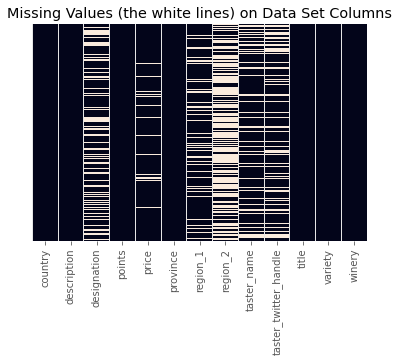

In [60]:
# Processing missing values
ax = sns.heatmap(df.isna(), cbar=False)
plt.title('Missing Values (the white lines) on Data Set Columns')
ax.axes.get_yaxis().set_visible(False)
plt.show()

In [61]:
#Proportion of missing values per column in descending order
np.round(df.isna().sum()/len(df),4).sort_values(ascending=False)

region_2                 0.6114
designation              0.2883
taster_twitter_handle    0.2402
taster_name              0.2019
region_1                 0.1635
price                    0.0692
province                 0.0005
country                  0.0005
winery                   0.0000
variety                  0.0000
title                    0.0000
points                   0.0000
description              0.0000
dtype: float64

In [62]:
# Checking for Missing values; 
wine = df.copy()

# region_1, region_2, twitter_handle and designation columns are going to to be removed. 
#Reasons: region_2 has 61% of records with missing values, also for the current analysis the regions don't offer any offer extra information that
#I can't get from country and province.
# The designation is already on the title which has not missing values.
#taster_twitter_handle doesn't offer any useful information.

wine.drop(['region_1','region_2','taster_twitter_handle', 'designation'], axis=1, inplace=True)



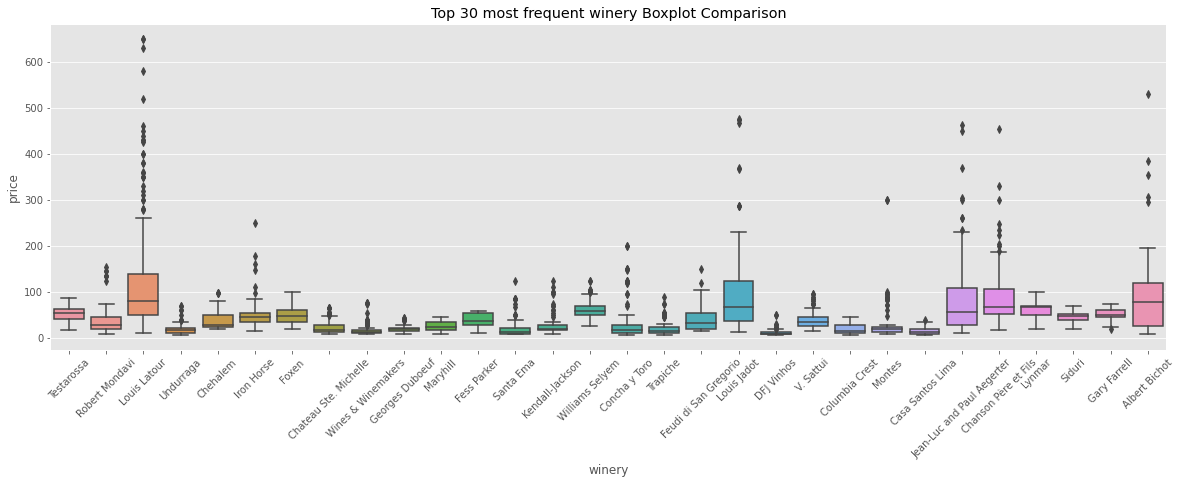

In [63]:
# For price replace the missing values with the mean price per winery, the same prices seem very close for each winery
wine.loc[wine['winery'].isin(list(wine['winery'].value_counts().head(20).index))]
plt.figure(figsize=(20,6))
sns.boxplot(x='winery', y='price', data=wine.loc[wine['winery'].isin(list(wine['winery'].value_counts().head(30).index))])
plt.title('Top 30 most frequent winery Boxplot Comparison')
plt.xticks(rotation=45)
plt.show()

In [64]:
wine['mean_price'] =  wine['winery'].map(dict(wine.groupby('winery')['price'].mean()))
wine['price'] = np.where(wine['price'].isna(), wine['mean_price'], wine['price'])
wine.drop('mean_price', axis=1, inplace=True)

### Creating new columns

In [65]:
# Binning the price in intervals of $100
wine['price_range'] = pd.cut(wine['price'], bins=33,precision=0)

#Binning the points in intervals of 5
wine['points_range'] = pd.cut(wine['points'], bins=5)

# Creating log transformation for price for easier visualization
#wine['log(price)'] = np.log(wine['price'])

# Column for made in USA or somewhere else.
wine['USA'] = np.where(wine['country']=='US', 'yes', 'no')

#Extracting the year (vintage) from the title.
wine['vintage'] = wine['title'].str.extract(pat=r'([1-2]\d{3})').astype(float)

#Count of all the characters in each review description
wine['desc_length'] = wine['description'].apply(len)

In [66]:
#Collecting the Externa data to estimate the wine wariety between red and white 

wiki_grapes = pd.read_html('https://en.wikipedia.org/wiki/List_of_grape_varieties')
red = wiki_grapes[0]
white = wiki_grapes[1]
red['variety'] = 'red'
white['variety'] = 'white'
grapes = pd.concat([red, white], ignore_index=True)
grapes['names'] = grapes['Common Name(s)']
grapes = grapes[['names', 'variety']]
wine.dropna(subset = ['variety'],axis=0, inplace=True)

def wine_var(v):    
    if 'red' in v.lower():
        return 'red'
    elif 'white' in v.lower():
        return 'white'
    else:    
        s = v.split()[0]
        try:
            return grapes.loc[grapes['names'].str.contains(s)]['variety'].iloc[0]
        except:
            return np.NaN
        
# Warning: this code will take a few minutes to finish execution, be patient.
var_test = wine['variety'].apply(wine_var)
wine['grape_variety'] = var_test

In [67]:
# #Replace missing taster name with unknown
# wine['taster_name'] = wine['taster_name'].fillna('unknown')
# #Replacing missing values on grape_variety with unknown
# wine['grape_variety'] = wine['grape_variety'].fillna('unknown')

#Drop the observations with missing values on country, title, these are only a few. 
#I'll also drop the records with missing price, taster_name and variety. It's possible to impute this data with the information from the other columns
# But I want to simplify this process
wine.dropna(subset = ['country', 'price','grape_variety','taster_name'],axis=0, inplace=True)

### Finishing Cleaning the Data

In [68]:
#Removing any extra records with missing values
wine.dropna(axis=0, inplace=True)

#Converting vintage to integer
#wine['vintage'] = wine['vintage'].astype(int)

#Renaming the column points to rating to avoid confusion
wine.rename({'points':'rating'}, axis=1, inplace=True)

In [69]:
#Finding and removing duplicated rows
print('This data set has ' + str(wine.duplicated().sum()) + ' duplicated records.')

This data set has 7626 duplicated records.


In [70]:
wine = wine[~wine.duplicated(subset=['description', 'taster_name'])]

In [71]:
#Clean data
wine.head()

,country,description,rating,price,province,taster_name,title,variety,winery,price_range,points_range,USA,vintage,desc_length,grape_variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,17.0,Sicily & Sardinia,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"(1.0, 104.0]","(84.0, 88.0]",no,2013.0,172,white
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"(1.0, 104.0]","(84.0, 88.0]",no,2011.0,227,red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"(1.0, 104.0]","(84.0, 88.0]",yes,2013.0,186,red
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"(1.0, 104.0]","(84.0, 88.0]",yes,2013.0,199,white
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"(1.0, 104.0]","(84.0, 88.0]",yes,2012.0,249,red


# Exploratory Data Analysis

### Numerical Variables

In [72]:
# Summary Statistics for Numerical Variables
wine.describe()

,rating,price,vintage,desc_length
count,83837.000000,83837.000000,83837.000000,83837.000000
mean,88.709627,37.080464,2011.147656,246.694180
std,3.007297,52.294386,9.682284,65.587179
min,80.000000,4.000000,1000.000000,20.000000
25%,87.000000,17.000000,2010.000000,202.000000
50%,89.000000,26.000000,2012.000000,241.000000
75%,91.000000,43.000000,2014.000000,286.000000
max,100.000000,3300.000000,2017.000000,829.000000


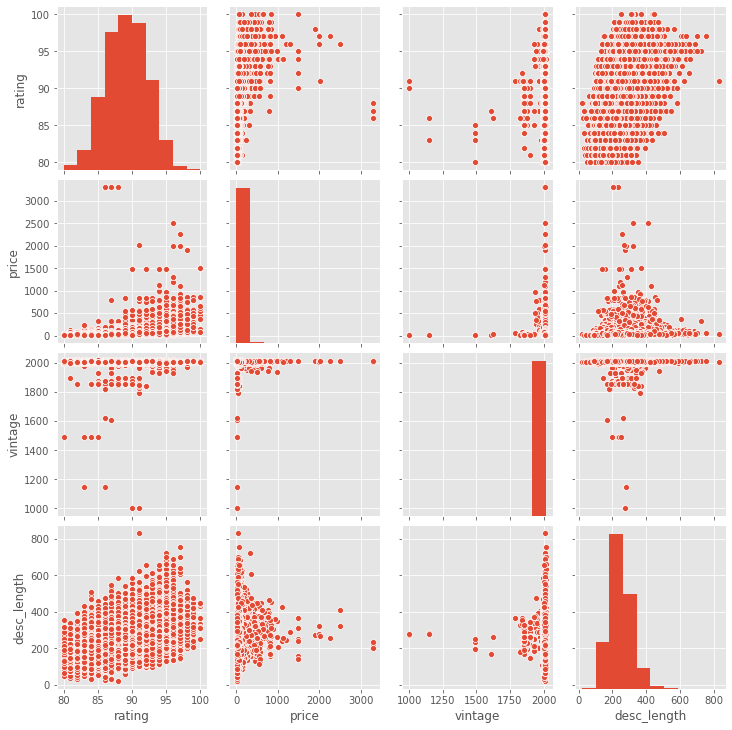

In [73]:
sns.pairplot(wine)
plt.show()

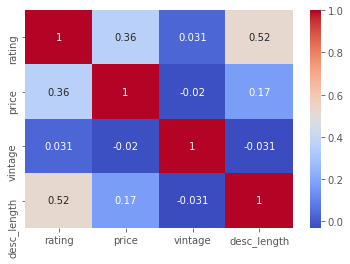

In [74]:
sns.heatmap(wine.corr(), annot=True, cmap='coolwarm')
plt.show()

As shown in the correlation matrix and the scatter plots, there doesn't seem any highly correlated variables. The highest is desc_length with rating, which could indicate that a the longest the review the higher the rating most likely be. For the distributions, description length and rating look fairly normal. Vintage is very skewed to the left which makes as most of the reviews come from wines from recent decades (there are some wines that a hundred year old). The price distribution is skewed to the right because there are a few very expensive wines, and most of them are cost below $100.

### Categorical Variables

In [75]:
# Summary Statistics for Categorical Variables
wine.describe(include=np.object)

,country,description,province,taster_name,title,variety,winery,USA,grape_variety
count,83837,83837,83837,83837,83837,83837,83837,83837,83837
unique,41,83836,396,19,83430,418,13022,2,2
top,US,In 2009 this single vineyard offering includes...,California,Roger Voss,Château Malartic-Lagravière 2007 Pessac-Léognan,Pinot Noir,Georges Duboeuf,no,red
freq,32375,2,17240,18828,3,9221,185,51462,60356


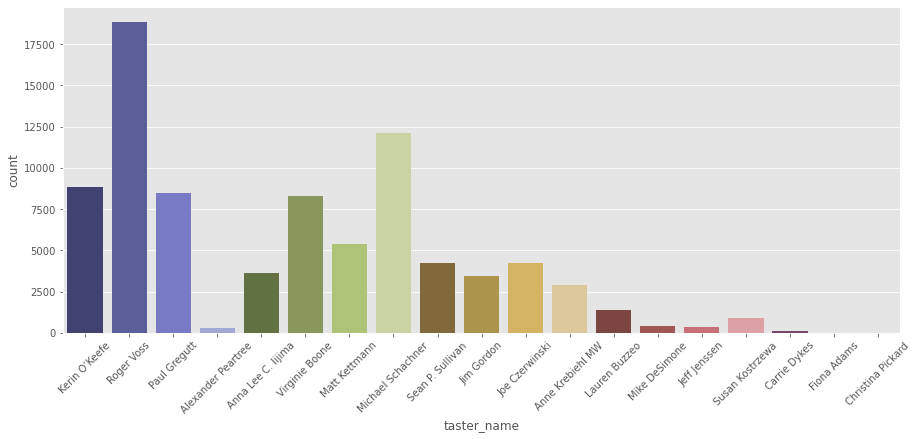

Roger Voss had the most amounf of reviews


In [76]:
plt.figure(figsize=(15,6))
sns.countplot(x='taster_name', data=wine.query('taster_name != "unknown"'), palette='tab20b')
plt.xticks(rotation=45)
plt.show()
print('Roger Voss had the most amounf of reviews')

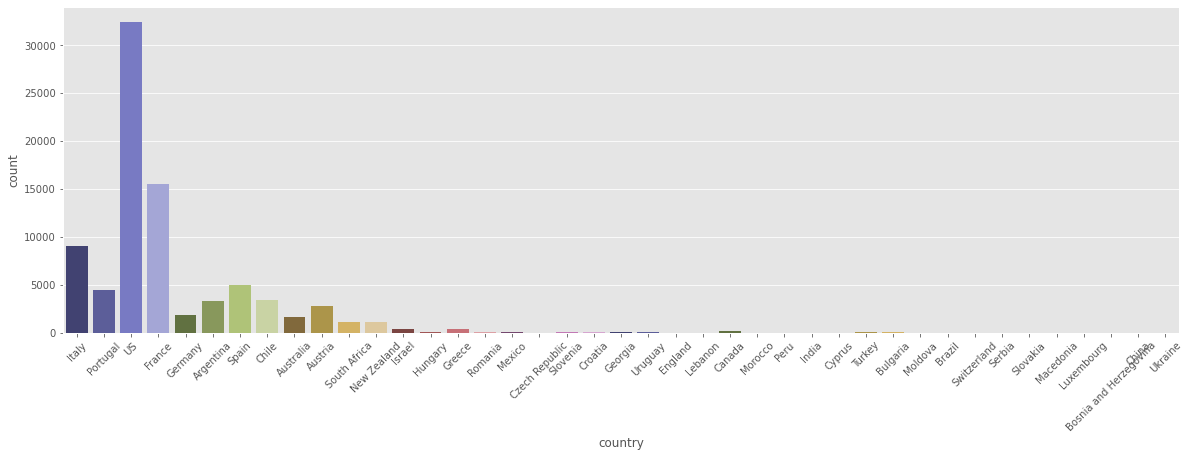

Most of the wines come from the USA


In [77]:
plt.figure(figsize=(20,6))
sns.countplot(x='country', data=wine,palette='tab20b')
plt.xticks(rotation=45)
plt.show()
print('Most of the wines come from the USA')

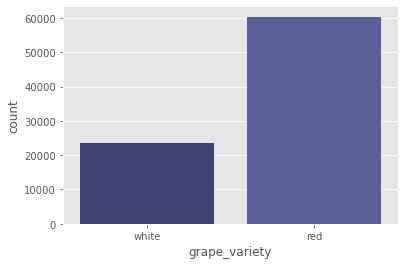

In [78]:
sns.countplot(x='grape_variety', data=wine,palette='tab20b')
plt.show()

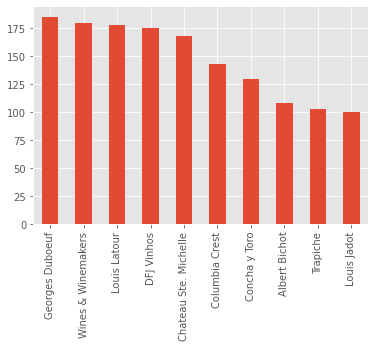

In [79]:
#Top 10 more frequent wineries
wine['winery'].value_counts().head(10).plot.bar()
plt.show()

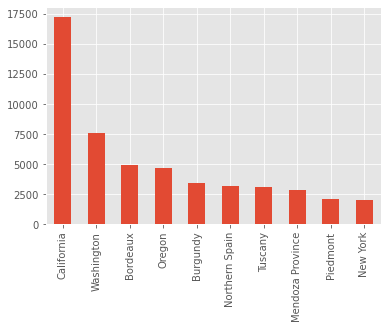

In [80]:
#Top ten more frequent provinces
wine['province'].value_counts().head(10).plot.bar()
plt.show()

### Further Analysis

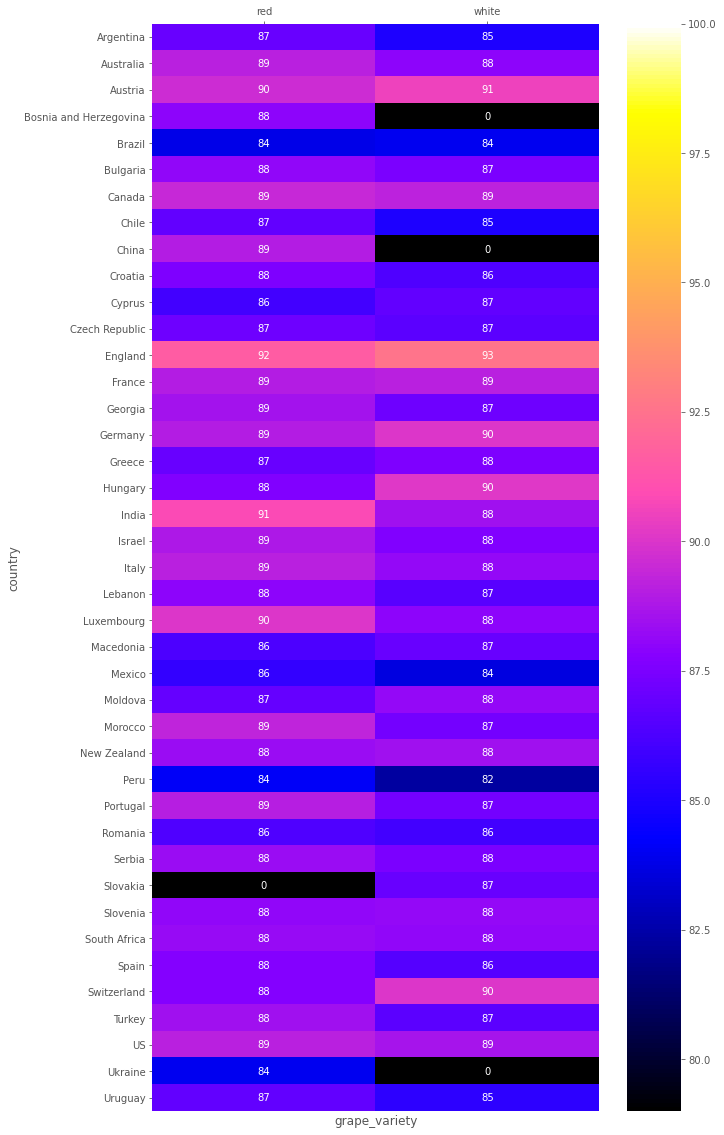

In [81]:
#Comparing rating per country and wine variety
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(wine.query('grape_variety != "unknown"').pivot_table(values='rating', index='country', columns='grape_variety').fillna(0), cmap='gnuplot2',vmax=100, vmin=79, ax=ax, annot=True)
ax.xaxis.tick_top()
#ax.set_xticklabels(['red','r','unknown'])
plt.show()

In [82]:
#Based on this heatmap, it looks like white wines from England are rated the highest, while white wines from Peru are rated the lowest

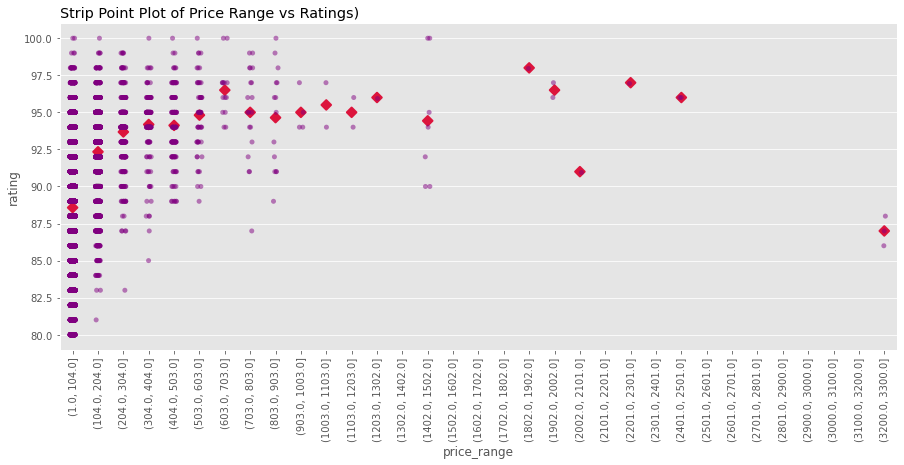

In [83]:
######################

plt.figure(figsize=(15,6))
plt.style.use('ggplot')
sns.stripplot(x="price_range", 
              y="rating", 
              data=wine,
              color='purple',
              alpha=0.5)
sns.pointplot(x="price_range", 
              y="rating",
              markers="D", 
              linestyles='', 
              data=wine, 
              ci=None, 
              estimator=np.mean,
              color='crimson')
plt.title('Strip Point Plot of Price Range vs Ratings)', loc='left')
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [84]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

text = " ".join(r for r in wine['description'])

custom_stop_words = ['flavor','flavors','wine','drink']
stop_words = set(stopwords.words('english'))
stop_words.update(custom_stop_words)
  
word_tokens = word_tokenize(text) 
word_tokens = [w.lower() for w in word_tokens]
filtered_sentence = [w for w in word_tokens if not w in stop_words]

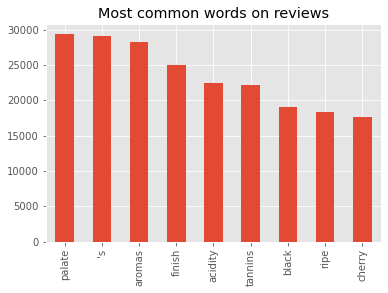

In [85]:
#Most common word used on the reviews
pd.Series(filtered_sentence).value_counts().head(20)[3:12].plot.bar(title='Most common words on reviews')
plt.show()

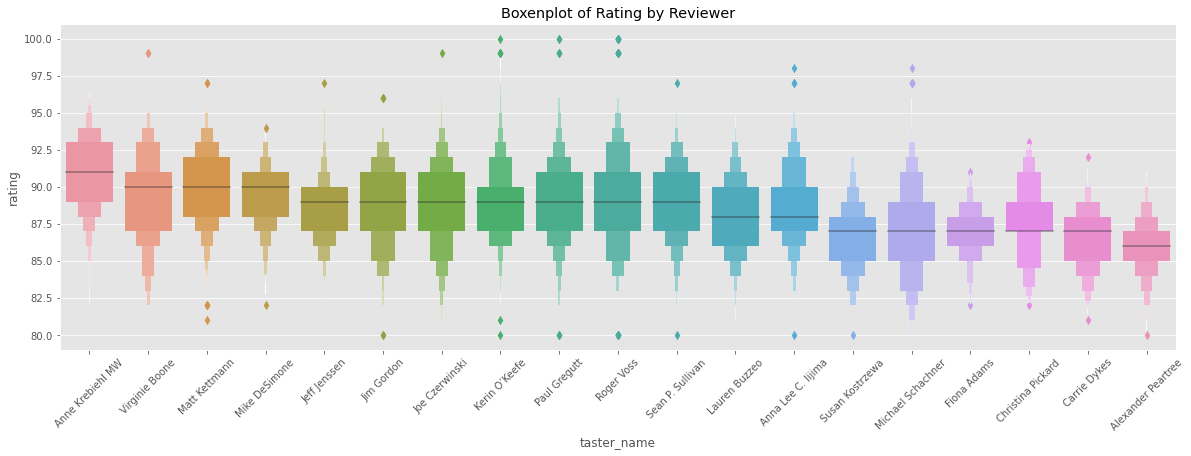

In [86]:
# ranks by tester names
plt.figure(figsize=(20,6))
orde = wine.query('taster_name != "unknown"').groupby('taster_name')['rating'].median().sort_values(ascending=False).index
sns.boxenplot(x='taster_name', y='rating', data=wine.query('taster_name != "unknown"'), order=orde)
plt.xticks(rotation=45)
plt.title('Boxenplot of Rating by Reviewer')
plt.show()

In [87]:
# This boxplot shows how the distribution of the rating for each taster gives on his review for the wines. It's sorted in descending order by the median.
# Usually Anne Krebiehl rated the wines on the higher end of the rating, while Alexander Peartree does the opposite. 
#Also notice how tight is the distribution for Fiona Adams it looks like this taster is very convervative with the ratings, staying on the same range, the lack of outliers shows that.

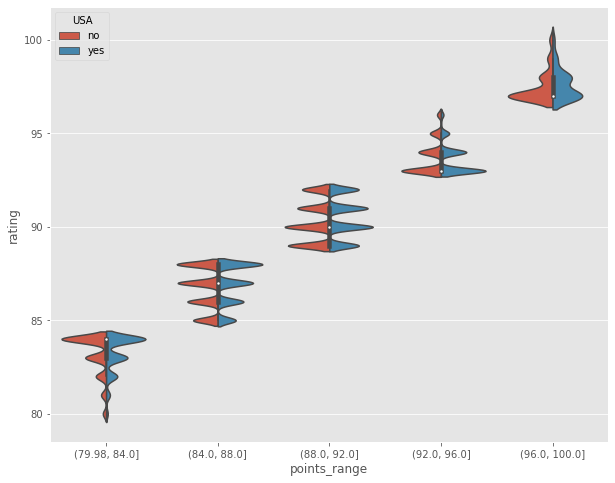

In [88]:
plt.figure(figsize=(10,8))
sns.violinplot(x="points_range", y="rating", hue="USA", split=True, data=wine);

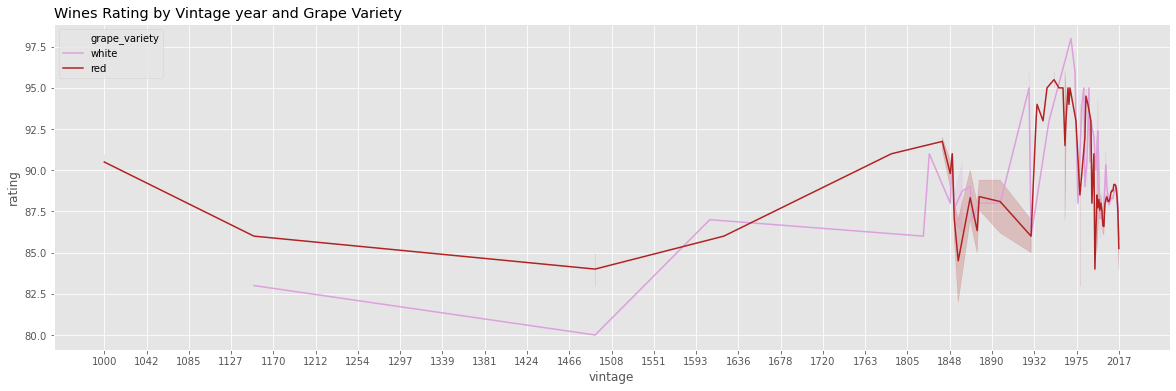

In [89]:
plt.figure(figsize=(20,6))
yea = 1900
sns.lineplot(x='vintage', y = 'rating', data=wine.query('grape_variety != "unknown"'), estimator='mean', hue = 'grape_variety', palette=['plum','firebrick'])
plt.title('Wines Rating by Vintage year and Grape Variety', loc='left')
plt.xticks(np.linspace(1000, 2017, 25))
plt.show()

In [90]:
#Wines from between 1845 and 1980 have the highest rating.

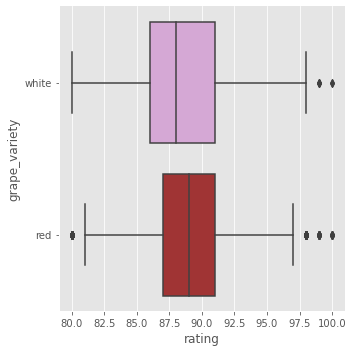

In [91]:
#Difference on rating between wine varieties
sns.catplot(kind='box', x='rating', y ='grape_variety', data=wine.query('grape_variety != "unknown"'), orient='h', palette=['plum','firebrick'])
plt.show()

In [92]:
#Based on the boxplot there doesn't seem to be difference on how taster rate on average red and white wines.
wine.groupby('grape_variety')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
grape_variety,,,,,,,,
red,60356.0,88.763619,3.004695,80.0,87.0,89.0,91.0,100.0
white,23481.0,88.570845,3.009599,80.0,86.0,88.0,91.0,100.0


In [93]:
wine['vintage'] = wine['vintage'].astype(int)
wine = wine[['title','country','description','desc_length','rating','price','taster_name','grape_variety','vintage']]
wine.to_csv('clean_wine.csv', index=False)

In [94]:
!python --version

Python 3.8.3
